In [1]:
import matplotlib.pyplot as plt
import torch

from cheetah import ParticleBeam, CrabCavity, Segment
from cheetah.utils.bmadx import bmad_to_cheetah_coords, cheetah_to_bmad_coords

import os

torch.set_printoptions(precision=15, sci_mode=True)

In [58]:
# Incoming beam
coords = torch.ones((1, 10000, 7))
coords[..., :-1] = torch.randn((1, 10000, 6)) * 1e-3
energy = torch.tensor([1e9])
incoming = ParticleBeam(particles=coords, energy=energy, dtype=torch.float64)
print(f"particles shape: {incoming.particles.shape}")
print(f"energy shape: {incoming.energy.shape}")

particles shape: torch.Size([1, 10000, 7])
energy shape: torch.Size([1])


In [59]:
# Test if coordinate transormation is correct
from scipy.constants import physical_constants

mc2 = torch.tensor(
    physical_constants["electron mass energy equivalent in MeV"][0] * 1e6,
    dtype=torch.float64,
)
bmad_coords, p0c = cheetah_to_bmad_coords(
    incoming.particles, incoming.energy, mc2
)
test_coords, test_ref_energy = bmad_to_cheetah_coords(bmad_coords, p0c, mc2)
print(torch.allclose(incoming.energy, test_ref_energy, atol=0, rtol=1e-14))
print(torch.allclose(incoming.particles, test_coords, atol=1e-14, rtol=1e-14))

True
True


In [60]:
test_ref_energy

tensor([1.000000000000000e+09], dtype=torch.float64)

In [61]:
l = torch.tensor([1.0])
voltage = 1.0e7
phase = 0.2
frequency = 1.0e9

# Bmad-X tracking method
cheetah_tdc_bmadx = CrabCavity(
    l,
    voltage,
    phase,
    frequency,
    tracking_method="bmadx",
    dtype=torch.double,
)
cheetah_bmadx_outgoing_beam = cheetah_tdc_bmadx.track(incoming)

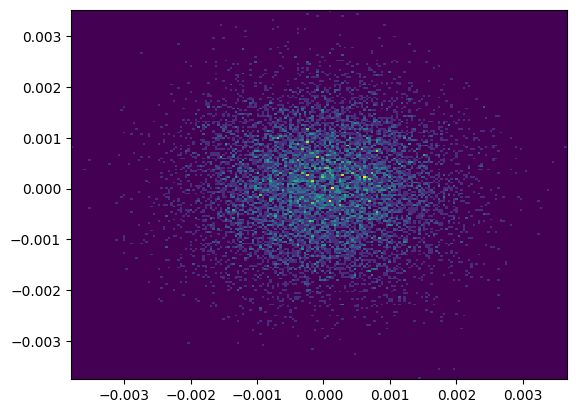

In [62]:
# Initial y-py phase space
plt.hist2d(incoming.particles[0, :, 2], incoming.particles[0, :, 3], bins=200)
plt.show()

In [63]:
cheetah_bmadx_outgoing_beam.particles[0, :, 0]

tensor([6.813537073140016e-03, 2.734805872684217e-03, 3.550934267809699e-03,
         ..., 3.529411408966884e-03, 4.627278971400567e-03,
        6.911508254188677e-03], dtype=torch.float64)

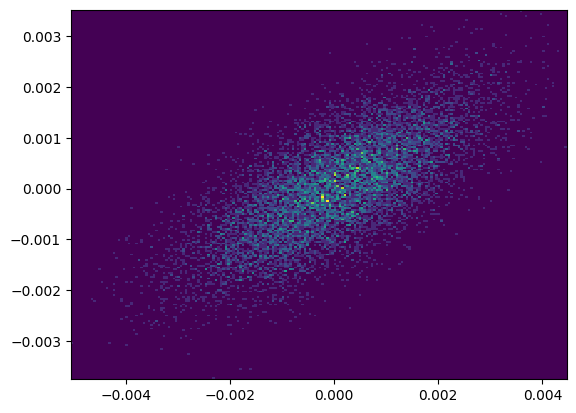

In [64]:
# Bmad-X tracking method output y-py phase space: chromatic effects:
plt.hist2d(
    cheetah_bmadx_outgoing_beam.particles[0, :, 2],
    cheetah_bmadx_outgoing_beam.particles[0, :, 3],
    bins=200,
)
plt.show()

In [65]:
# Compare against Bmad-X package
from bmadx.bmad_torch.track_torch import Beam, TorchCrabCavity, TorchLattice

bmadx_beam = Beam(data=bmad_coords, p0c=p0c, mc2=mc2)
bmadx_tdc = TorchCrabCavity(
    L=torch.tensor(l),
    VOLTAGE=torch.tensor(voltage),
    RF_FREQUENCY=torch.tensor(frequency),
    PHI0=torch.tensor(phase))
bmadx_lattice = TorchLattice([bmadx_tdc])
bmadx_out_coords = torch.stack(bmadx_lattice(bmadx_beam)[:6], dim=-1)
bmadx_out_with_cheetah_coords, ref_energy = bmad_to_cheetah_coords(
    bmadx_out_coords, p0c, mc2
)

/var/folders/h2/0svjf60s08307h9svgy94lb00000gn/T/ipykernel_32701/3414382966.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L=torch.tensor(l),


In [66]:
bmadx_out_coords[0,:,0]

tensor([6.813537102968207e-03, 2.734805900114091e-03, 3.550934294646932e-03,
         ..., 3.529411435562194e-03, 4.627278998404695e-03,
        6.911508286844108e-03], dtype=torch.float64)

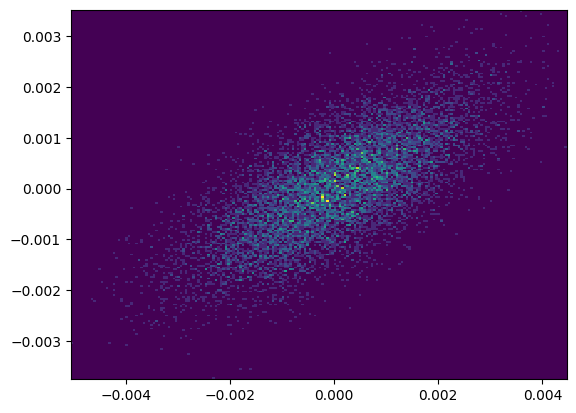

In [67]:
# Bmad-X package tracking output y-py phase space: chromatic effects:
plt.hist2d(
    bmadx_out_with_cheetah_coords[0, :, 2],
    bmadx_out_with_cheetah_coords[0, :, 3],
    bins=200,
)
plt.show()

In [70]:
# Compare against cheetah with Bmad-X tracking method (expected to be the same)
print(
    torch.allclose(
        bmadx_out_with_cheetah_coords,
        cheetah_bmadx_outgoing_beam.particles,
        atol=1e-10,
        rtol=1e-10,
    )
)
# For some reason, Bmad-X results only agree to single precision.

True


In [72]:
# Save tensors for tests
torch.save(bmadx_out_with_cheetah_coords, "incoming_beam_cavity.pt")
torch.save(bmadx_out_with_cheetah_coords, "drift_bmadx_out_with_cheetah_coords.pt")